In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from collections import deque, namedtuple 

# Plotting configuration
sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Gymnasium Version: {gym.__version__}")

# For reproducibility and device selection
torch.manual_seed(42)
np.random.seed(42)
random.seed(42) # For Python's random module
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.3.0+cu118
Gymnasium Version: 1.1.1
Using device: cuda


In [2]:
# Environment setup (CartPole)
env_name = 'CartPole-v1'
try:
    env = gym.make(env_name)
except gym.error.DeprecatedEnv:
    env = gym.make('CartPole-v0')

In [3]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [4]:
state_dim_rl = env.observation_space.shape[0]
action_dim_rl = env.action_space.n
print(state_dim_rl, action_dim_rl)
env.close()

4 2


### Deep Q-Networks (DQN)

In [5]:
# MLP for cartpole
class QNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_q_values = nn.Linear(hidden_dim, action_dim)

    def forward(self, state_tensor):
        x = F.relu(self.fc1(state_tensor))
        x = F.relu(self.fc2(x))
        q_values = self.fc3_q_values(x)
        return q_values    

In [19]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [20]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [21]:
# epsilon greedy action selection
def select_action_epsilon_greedy(state_tensor, policy_net, epsilon, n_actions):
    if random.random() > epsilon:
        with torch.no_grad():
            if state_tensor.ndim == 1:
                state_tensor = state_tensor.unsqueeze(0)
            action = policy_net(state_tensor).max(1)[1].view(1, 1)
            return action
    else:       # choose a random action
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [22]:
# DQN Algorithm Implementation
buffer_size = 10000
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
target_update_freq = 10
lr = 1e-3
num_episodes = 600
max_steps = 500

In [23]:
# Initialize Q-network (policy_net) and Target Q-Network (target_net)
policy_q_net = QNetwork(state_dim_rl, action_dim_rl).to(device)
target_q_net = QNetwork(state_dim_rl, action_dim_rl).to(device)
target_q_net.load_state_dict(policy_q_net.state_dict())
target_q_net.eval()

QNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3_q_values): Linear(in_features=128, out_features=2, bias=True)
)

In [24]:
optimizer = optim.AdamW(policy_q_net.parameters(), lr=lr, amsgrad=True)
replay_memory = ReplayBuffer(buffer_size)

In [25]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [26]:
replay_memory

In [27]:
steps_done = 0
episode_rewards = []
for episode_i in range(num_episodes):
    dqn_env = gym.make(env_name)
    state_np_dqn, info_dqn = dqn_env.reset(seed=42 + episode_i)
    state_dqn = torch.from_numpy(state_np_dqn).float().unsqueeze(0).to(device)

    current_episode_reward = 0

    for t_dqn in range(max_steps):
        epsilon = eps_end + (eps_start - eps_end) * np.exp(-1. * steps_done / eps_decay)
        steps_done += 1

        action_dqn = select_action_epsilon_greedy(state_dqn, policy_q_net, epsilon, action_dim_rl)

        next_state_np_dqn, reward_dqn, terminated_dqn, truncated_dqn, _ = dqn_env.step(action_dqn.item())
        done_dqn = terminated_dqn or truncated_dqn
        current_episode_reward += reward_dqn

        reward_tensor_dqn = torch.tensor([reward_dqn], device=device, dtype=torch.float32)
        done_tensor_dqn = torch.tensor([done_dqn], device=device, dtype=torch.bool)

        if terminated_dqn:
            next_state_dqn = None
        else:
            next_state_dqn = torch.from_numpy(next_state_np_dqn).float().unsqueeze(0).to(device)

        # store the transition in replay memory
        replay_memory.push(state_dqn, action_dqn, next_state_dqn, reward_tensor_dqn, done_tensor_dqn)

        # move to the next state
        state_dqn = next_state_dqn

        # perform one step of optimization on the policy network
        if len(replay_memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            # compute a mask of non-final states and concatenate the batch elements
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                          device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)      # [batch_size, 1]
            reward_batch = torch.cat(batch.reward)      # [batch_size]
            done_batch = torch.cat(batch.done)          # [batch_size]

            state_action_values = policy_q_net(state_batch).gather(1, action_batch)     # Q(s,a)

            # Compute V(s_{t+1}) for all next states.
            next_state_values = torch.zeros(batch_size, device=device)
            if non_final_next_states.nelement() > 0:
                with torch.no_grad():
                    next_state_values[non_final_mask] = target_q_net(non_final_next_states).max(1)[0]

            # compute expected Q Values (Bellman target)
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            # for terminal states, future reward component (next_state_values * gamma) is zero because next_state_values for done states will be zero

            # compute Huber loss or MSE loss
            criterion = nn.SmoothL1Loss() 
            # criterion = nn.MSELoss()
            loss_dqn = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

            # optimize the model
            optimizer.zero_grad()
            loss_dqn.backward()
            torch.nn.utils.clip_grad_value_(policy_q_net.parameters(), 100)
            optimizer.step()

        if done_dqn:
            break

    dqn_env.close()
    episode_rewards.append(current_episode_reward)

    # update the target network
    if episode_i % target_update_freq == 0:
        target_q_net.load_state_dict(policy_q_net.state_dict())

    if (episode_i) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"DQN Episode {episode_i+1}/{num_episodes}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")
        if avg_reward >= 475.0 and num_episodes > 100:
            print(f"CartPole solved by DQN at episode {episode_i+1}!")

DQN Episode 1/600, Avg Reward (last 50): 9.00, Epsilon: 0.893
DQN Episode 51/600, Avg Reward (last 50): 61.58, Epsilon: 0.089
DQN Episode 101/600, Avg Reward (last 50): 168.92, Epsilon: 0.050
DQN Episode 151/600, Avg Reward (last 50): 163.00, Epsilon: 0.050
DQN Episode 201/600, Avg Reward (last 50): 93.72, Epsilon: 0.050
DQN Episode 251/600, Avg Reward (last 50): 115.88, Epsilon: 0.050
DQN Episode 301/600, Avg Reward (last 50): 119.94, Epsilon: 0.050
DQN Episode 351/600, Avg Reward (last 50): 125.34, Epsilon: 0.050
DQN Episode 401/600, Avg Reward (last 50): 151.92, Epsilon: 0.050
DQN Episode 451/600, Avg Reward (last 50): 174.32, Epsilon: 0.050
DQN Episode 501/600, Avg Reward (last 50): 118.84, Epsilon: 0.050
DQN Episode 551/600, Avg Reward (last 50): 152.68, Epsilon: 0.050


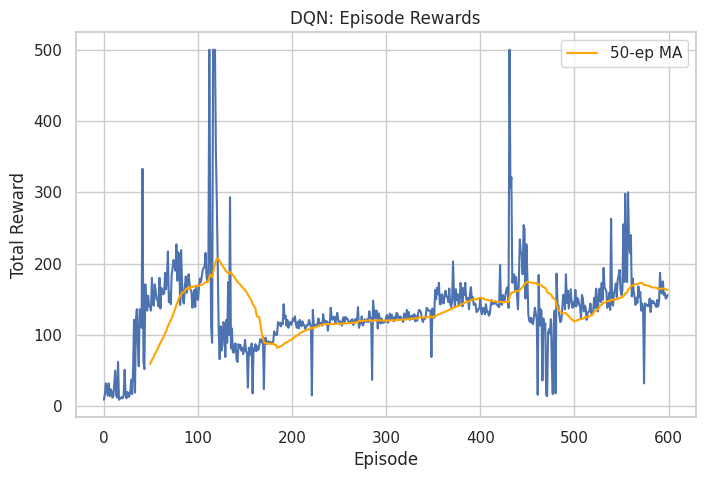

In [29]:
plt.figure(figsize=(8,5))
plt.plot(episode_rewards)
plt.title("DQN: Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
if len(episode_rewards) >= 50:
    rewards_ma_dqn = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(49, len(episode_rewards)), rewards_ma_dqn, label='50-ep MA', color='orange')
plt.legend()
plt.show()

### Actor-Critic Methods (Simple A2C)

- Actor: Policy network π_θ(a|s) - decides which action to take.
- Critic: Value network V_w(s) - estimates how good a state is.

In [31]:
# Actor critic network definition
class Actor(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_action_logits = nn.Linear(hidden_dim, action_dim)

    def forward(self, state_tensor):
        x = F.relu(self.fc1(state_tensor))
        x = F.relu(self.fc2(x))
        action_logits = self.fc3_action_logits(x)
        action_probs = F.softmax(action_logits, dim=-1)
        return action_probs

class Critic(nn.Module):

    def __init__(self, state_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_value = nn.Linear(hidden_dim, 1)   # outputs a single state value

    def forward(self, state_tensor):
        x = F.relu(self.fc1(state_tensor))
        x = F.relu(self.fc2(x))
        state_value = self.fc3_value(x)
        return state_value 

In [32]:
actor = Actor(state_dim_rl, action_dim_rl).to(device)
critic = Critic(state_dim_rl).to(device)

In [33]:
actor

Actor(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3_action_logits): Linear(in_features=128, out_features=2, bias=True)
)

In [34]:
critic

Critic(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3_value): Linear(in_features=128, out_features=1, bias=True)
)

In [35]:
lr_actor = 1e-3
lr_critic = 1e-3
optimizer_actor = optim.Adam(actor.parameters(), lr=lr_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=lr_critic)

In [41]:
# A2C training loop
a2c_num_episodes = 1500
max_steps, gamma

(500, 0.99)

In [53]:
episode_rewards_a2c = []

for episode_i_a2c in range(a2c_max_steps):
    a2c_env = gym.make(env_name)
    state_np_ac, info_ac = a2c_env.reset(seed=42 + episode_i_a2c)
    state_ac = torch.from_numpy(state_np_ac).float().unsqueeze(0).to(device)
    
    log_probs_ep = []
    values_ep = []
    rewards_ep = []
    masks_ep = [] # To indicate non-terminal states for value bootstrapping
    entropy_terms_ep = [] 

    current_episode_reward_a2c = 0

    for t_ac in range(max_steps):
        action_probs_ac = actor(state_ac)
        value_ac = critic(state_ac) # V(s_t)

        dist_ac = Categorical(action_probs_ac)
        action_ac = dist_ac.sample()
        log_prob_ac = dist_ac.log_prob(action_ac)
        entropy = dist_ac.entropy().mean() # Optional entropy bonus

        next_state_np_ac, reward_ac, terminated_ac, truncated_ac, _ = a2c_env.step(action_ac.item())
        done_ac = terminated_ac or truncated_ac
        
        log_probs_ep.append(log_prob_ac)
        values_ep.append(value_ac)
        rewards_ep.append(torch.tensor([reward_ac], device=device, dtype=torch.float32))
        masks_ep.append(torch.tensor([1-done_ac], device=device, dtype=torch.float32)) # 1 if not done, 0 if done
        entropy_terms_ep.append(entropy)
        
        current_episode_reward_a2c += reward_ac
        state_ac = torch.from_numpy(next_state_np_ac).float().unsqueeze(0).to(device)

        if done_ac:
            break
    a2c_env.close()
    episode_rewards_a2c.append(current_episode_reward_a2c)
    episode_rewards_a2c

    # calculate returns and advantages
    log_probs_t = torch.cat(log_probs_ep)
    values_t = torch.cat(values_ep).squeeze(-1)
    rewards_t = torch.cat(rewards_ep).squeeze(-1)
    masks_t = torch.cat(masks_ep).squeeze(-1)

    # For Critic: target_value_t = r_t + γ * V(s_{t+1}) (if not terminal)
    #                            = r_t                 (if terminal)
    returns_critic_target = torch.zeros_like(rewards_t)
    discounted_sum_rewards_critic = 0.0
    if not done_ac:
        with torch.no_grad():
            # state_ac here is S_T (the state *after* the last action of the loop)
            discounted_sum_rewards_critic = critic_ac(state_ac).squeeze().item()

    for t_idx in reversed(range(len(rewards_t))):
        discounted_sum_rewards_critic = rewards_t[t_idx] + gamma * discounted_sum_rewards_critic * masks_t[t_idx]
        returns_critic_target[t_idx] = discounted_sum_rewards_critic

    advantages = returns_critic_target - values_t # Advantage A_t = G_t (target for V) - V(s_t) (current estimate)

    # Actor loss
    actor_loss = -(log_probs_t * advantages.detach()).mean() # .detach() advantages so no grad to critic from actor loss
    actor_loss

    # critic loss
    # critic learns to predict returns_critic_target
    critic_loss = F.mse_loss(values_t, returns_critic_target.detach())
    critic_loss

    # --- Update Actor and Critic ---
    optimizer_actor.zero_grad()
    actor_loss.backward()
    optimizer_actor.step()

    optimizer_critic.zero_grad()
    critic_loss.backward()
    optimizer_critic.step()

    if (episode_i_a2c + 1) % 50 == 0:
        avg_reward_a2c = np.mean(episode_rewards_a2c[-50:])
        print(f"A2C Episode {episode_i_a2c+1}/{a2c_num_episodes}, "
              f"Avg Reward (last 50): {avg_reward_a2c:.2f}, "
              f"Actor Loss: {actor_loss.item():.3f}, Critic Loss: {critic_loss.item():.3f}")
        if avg_reward_a2c >= 475.0 and a2c_num_episodes > 100:
            print(f"CartPole solved by A2C at episode {episode_i_a2c+1}!")
            # break

A2C Episode 50/1500, Avg Reward (last 50): 93.10, Actor Loss: 7.544, Critic Loss: 781.618
A2C Episode 100/1500, Avg Reward (last 50): 239.02, Actor Loss: -5.840, Critic Loss: 580.757
A2C Episode 150/1500, Avg Reward (last 50): 309.86, Actor Loss: -10.273, Critic Loss: 1373.469
A2C Episode 200/1500, Avg Reward (last 50): 134.22, Actor Loss: 3.328, Critic Loss: 204.846
A2C Episode 250/1500, Avg Reward (last 50): 161.78, Actor Loss: -1.088, Critic Loss: 56.943
A2C Episode 300/1500, Avg Reward (last 50): 279.56, Actor Loss: 4.454, Critic Loss: 197.652
A2C Episode 350/1500, Avg Reward (last 50): 471.60, Actor Loss: 6.872, Critic Loss: 682.376
A2C Episode 400/1500, Avg Reward (last 50): 495.64, Actor Loss: -2.482, Critic Loss: 481.383
CartPole solved by A2C at episode 400!
A2C Episode 450/1500, Avg Reward (last 50): 490.44, Actor Loss: 1.628, Critic Loss: 492.989
CartPole solved by A2C at episode 450!
A2C Episode 500/1500, Avg Reward (last 50): 355.88, Actor Loss: -2.237, Critic Loss: 324.16


Finished A2C Training.


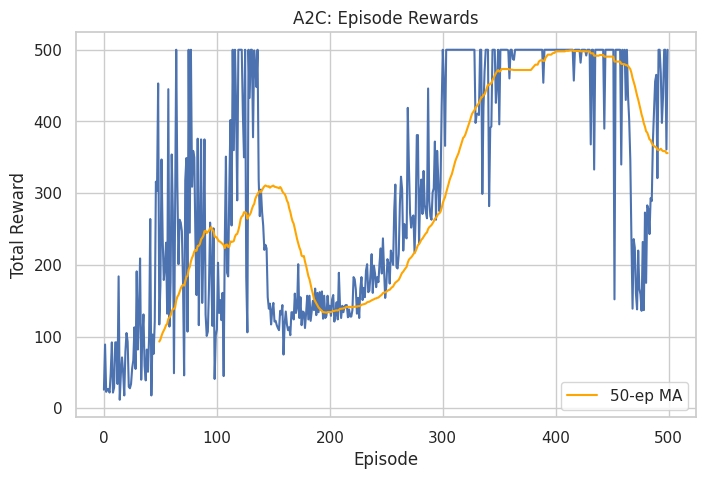

In [54]:
print("\nFinished A2C Training.")
plt.figure(figsize=(8,5))
plt.plot(episode_rewards_a2c)
plt.title("A2C: Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
if len(episode_rewards_a2c) >= 50:
    rewards_ma_a2c = np.convolve(episode_rewards_a2c, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(49, len(episode_rewards_a2c)), rewards_ma_a2c, label='50-ep MA', color='orange')
plt.legend()
plt.show()

#### Conclusion 
- DQN learns an action-value function (Q-function) using a Q-network, experience replay, and a target network to stabilize learning. It's off-policy.
- Actor-Critic methods learn both a policy (Actor) and a value function (Critic). The Critic helps evaluate actions taken by the Actor, often leading to more stable policy gradient updates by using an advantage estimate.